<a href="https://colab.research.google.com/github/lindermanlab/PPSeq/blob/main/notebooks/version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PPSeq with GPU support

The original PPSeq algorithm worked in continuous time and used a collapsed Gibbs sampler for nonparametric Bayesian inference. Unfortunately, the collapsed algorithm introduced serial dependencies that could make computation slow on some datasets. Here, we implement a simpler inference algorithm that works in discrete time takes advantage of parallelization across time bins using a GPU.

## Model

Like PPSeq, the model is a simple convolutional non-negative matrix factorization,

$$
\begin{align}
x_{n,t} &\sim \mathrm{Po}(\lambda_{n,t}) \\
\lambda_{n,t} &= b_n + \sum_{k=1}^K \sum_{d=1}^D a_{k,t-d} w_{k,n,d} \\
 &= b_n + \sum_{k=1}^K [\mathbf{a}_{k} \circledast \mathbf{w}_{k,n}]_t
\end{align}
$$
where
- $a_{k,t} \in \mathbb{R}_+$ is the **amplitude** of the $k$-th factor at time $t$.
- $w_{k,n,d}$ is the weight the $k$-th factor assigns to neuron $n$ at time delay $d$.
- $\circledast$ denotes a convolution.

A simple way to fit this model is by augmentation: we introduce latent **parent assignments** $z_{n,t,k}$ which specify how many of the spikes $x_{n,t}$ were attributed to each of the $KD+1$ factors (including the background). Given the parents, updating estimates of parametesr $\mathbf{a}$ and $\mathbf{w}$ is relatively straightforward.



## Augmentation

Let
$$
\begin{align}
z_{n,t,0} &\sim \mathrm{Po}(b_n) \\
z_{n,t,k,d} &\sim \mathrm{Po}(a_{k,t-d} w_{k,n,d})
\end{align}
$$
Then $x_{n,t} = z_{n,t,0} + \sum_k \sum_d z_{n,t,k,d}$ (in distribution). Moreover, given the sum, the parent variables are multinomial distributed with expectations,
\begin{align}
\mathbb{E}[z_{n,t,0} \mid x_{n,t}, \theta]
&= \frac{x_{n,t}}{\lambda_{n,t}} b_n \\
&= r_{n,t} b_n \\
\mathbb{E}[z_{n,t,k,d} \mid x_{n,t}, \theta]
&= \frac{x_{n,t}}{\lambda_{n,t}} a_{k,t-d} w_{k,n,d} \\
&= r_{n,t} a_{k,t-d} w_{k,n,d}
\end{align}
where $\theta = \{\mathbf{b}, \mathbf{a}_k, \mathbf{w}_k\}$ is the set of model parameters, and $r_{n,t} = \frac{x_{n,t}}{\lambda_{n,t}}$ are we call the **residual ratios**.


## Inference
## M-step for b
\begin{align}
L(b_n) = \log P(b_n|z_{n, t,0}, t\in[T])
&= \sum_t \log Po(z_{n, t,0}|b_n)+c\\
&= \sum_t z_{n,t,0}\log b_n - T b_n
\end{align}

maximized at $b_n = \sum_t\mathbb{E}[z_{n,t,0}]/T=\sum_t r_{n,t}b_n/T$




### M-step for the amplitudes
If we work with the log joint probability as a function of $\mathbf{a}_k$ is,
\begin{align}
L(\mathbf{a}_k)
&= \sum_{t=1}^T \sum_{n=1}^N \sum_{d=1}^D \log \mathrm{Po}(z_{n,t+d,k,d} \mid a_{k,t} w_{k,n,d}) + c\\
&= \sum_{t=1}^T \sum_{n=1}^N \sum_{d=1}^D z_{n,t+d,k,d} \log a_{k,t} - a_{k,t} w_{k,n,d} + c \\
&= \sum_{t=1}^T \log \mathrm{Ga}(a_{k,t} \mid \alpha_{k,t}+1, \beta_{k,t})
\end{align}
<!-- &= \sum_{t=1}^T \alpha_{k,t} \log a_{k,t} - \beta a_{k,t} -->
where
\begin{align}
\alpha_{k,t} &= \sum_{n=1}^N \sum_{d=1}^D z_{n,t+d,k,d} \\
\beta_{k,t} &= \sum_{n=1}^N \sum_{d=1}^D w_{k,n,d}
\end{align}

For EM, we need the expected value of the gamma parameters.
\begin{align}
\mathbb{E}[\alpha_{k,t}]
&= a'_{k,t} \sum_{n=1}^N \sum_{d=1}^D w_{k,n,d} \, r_{n,t+d} \\
&= a'_{k,t} [\mathbf{W}_k \ast \mathbf{R}]_t \\
\end{align}
where $a_{k,t}'$ are the amplitudes from the previous iteration and $\ast$ denotes the **cross-correlation** operation.

$\log \mathbb{E} p(x,z|\theta) \geq \text{(ELBO)} \mathbb{E}_{z\sim \text{multinomial}}[\log  p(x,z|\theta)] $

Focus only on $a_{k,t}$:

$\text{ELBO}(a_{k,t})=\sum_{n=1}^N \sum_{d=1}^D \mathbb{E}[z_{n,t+d,k,d}] \log a_{k,t} - a_{k,t} w_{k,n,d} $

It is maximized at $a_{k,t}=\frac{\mathbb{E}[\alpha_{k,t}]}{\beta_{k,t}}$

**See also:** These [notes](https://slinderman.github.io/stats320/lectures/05_deconv_spike_sorting.html#optimizing-the-amplitudes)

**TODO: We could put a simple HMM prior on $\mathbf{a}_k$ to prevent sequences from happening in quick succession.**


### M-step for the weights
As a function of the weights, the log joint probability is,
\begin{align}
L(\mathbf{w}_{k,n})
&= \sum_{d=1}^D \sum_{t=1}^T \log \mathrm{Po}(z_{n,t,k,d} \mid a_{k,t} w_{k,n,d}) + c \\
&= \sum_{d=1}^D \log \mathrm{Ga}(w_{k,n,d} \mid \alpha_{k,n,d}, \beta_{k,n,d})
\end{align}
where
\begin{align}
\alpha_{k,n,d} &= \sum_{t=1}^T z_{n,t,k,d} \\
\beta_{k,n,d} &= \sum_{t=T}^T a_{k,t}
\end{align}
In expectation,
\begin{align}
\mathbb{E}[\alpha_{k,n,d}]
&= w_{k,n,d}' \sum_{t=1}^T \frac{x_{n,t}}{\lambda_{n,t}} a_{k,t-d} \\
&= w_{k,n,d}' \sum_{t=1}^T \mathbf{r}_{n,t} a_{k,t-d}\\
&= w_{k,n,d}' [\mathbf{r}_{n} \circledast \mathbf{a}_k]_d
\end{align}



**TODO: We'll put a prior on the weights such that they are unimodal as a function of delay $d$ for each factor $k$ and neuron $n$. For example, we could constrain them to follow a scaled Gaussian density. Or maybe we could constrain the (finite difference estimate of the) second derivative of the log weights to be negative for all $d$.**

## Next Steps
1. Read NSP papers (Wang et al, JASA 2023; Williams et al, NeurIPS 2020) introduce the general model and collapsed Gibbs samplign algorithm.
2. Read the notes above on convolution spike sorting because that has some similar tricks.
3. Try implementing the model in pytorch (again following the notes and the corresponding [homework](https://slinderman.github.io/stats320/labs/01_spike_sorting.html))
4. Simulate some data and make sure you can recover underlying amplitudes (also think about learning the weights as described above?)
5. Contact Nick Steinmetz (UW) to test it on spike train data
6. Model iteration: imposing changepoint prior on the latent events? accounting for low dimensional activity in the spike data, ...

Also,
5b. Come up with a 2d imaging version of the model
6b. Contact Wes Tansey at MSK about spatial genomics and cancer data (fit model and iterate)



In [94]:
!git clone https://github.com/lindermanlab/PPSeq.git
%cd PPSeq

Cloning into 'PPSeq'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 51 (delta 13), reused 25 (delta 6), pack-reused 0
Receiving objects: 100% (51/51), 206.20 KiB | 1.56 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/PPSeq


In [ ]:
!git pull

Already up to date.


In [95]:
from src.plot_tools import plot_model
from src.generate_data import generate, generate_data
from src.em import pred, log_probability, m_step, em

# Import PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
import torch.optim as optim

# Plotting stuff
import matplotlib.pyplot as plt

# Some helper utilities
from tqdm.auto import trange

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not torch.cuda.is_available():
    print('cpu')

cpu


In [96]:
import pandas as pd
import math
import numpy as np
url = 'https://raw.githubusercontent.com/lindermanlab/PPSeq/main/src/songbird_spikes.txt'
#url = url.format(username='lindermanlab', repository='PPSeq', branch='main', path_to_file='src/songbird_spikes.txt')
df = pd.read_csv(url, delimiter='\t', header=None)
x = df.groupby(0)[1].apply(list).to_numpy()

T = 223 # df[1].max()
n = 75
X = torch.zeros(n, T)
for i, neuron in enumerate(x):
  for spike in neuron:
    X[i, math.ceil(spike*10)] += 1
X = X[~torch.all(X == 0, dim=1)]

  0%|          | 0/100 [00:00<?, ?it/s]

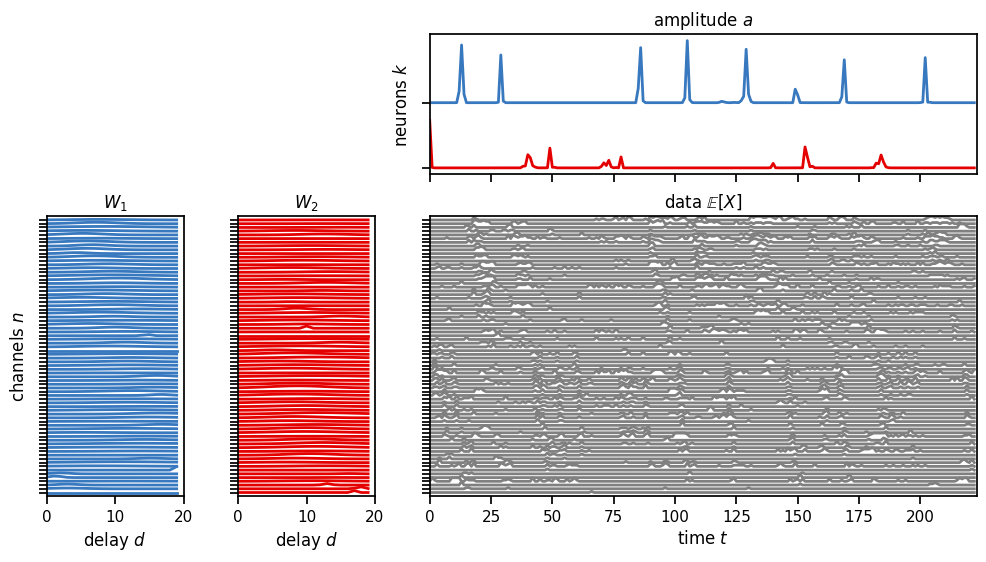

In [97]:
D = 20    # duration of a spike (in samples)
K = 2      # neurons
b_pred, a_pred, w_pred, lps,scale, mu, log_sigma = em(X, K, D, n_iter=100)
plot_model(w_pred.detach(), a_pred.detach(), X)

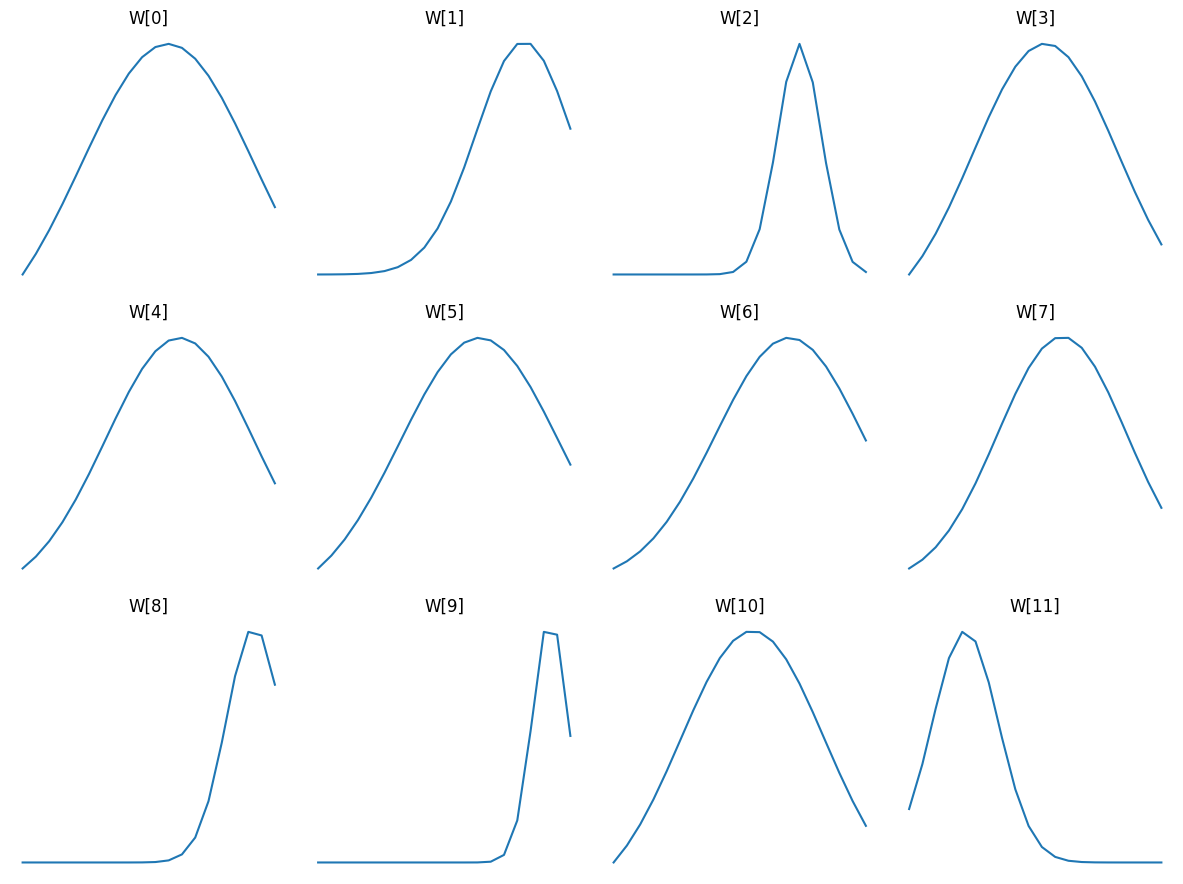

In [ ]:
fig, axs = plt.subplots(3, 4, figsize=(12, 9))

for i in range(3):
    for j in range(4):
        index = i * 4 + j
        axs[i, j].plot(w_pred.detach()[0][index])  # Assuming you want to visualize the tensor
        axs[i, j].set_title(f'W[{index}]')
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

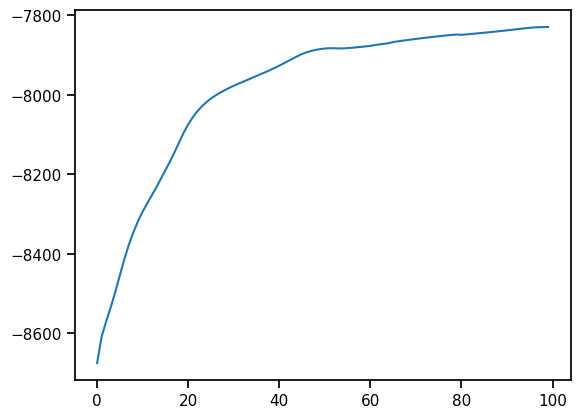

In [98]:
plt.plot(lps)

In [ ]:
#@title old em no prior
def log_probability(X, a, b, W):
  """
  calculate the log probability given data X and estimated parameters a, b, W
  """
  N, T = X.shape
  K, N, D = W.shape
  lambda_nt = b.view(N,1) + F.conv1d(a, torch.flip(W.permute(1,0,2),[2]), padding=D-1)[:,:-D+1]
  lambda_nt = torch.clamp(lambda_nt, min=1e-5)
  return torch.sum(dist.Poisson(lambda_nt).log_prob(X))

def m_step(X, b, a, W):
  """
  Args:
    - X: (N, T)
    - b: (N)
    - a: (K, T)
    - W: (K, N, D)

  Returns:
  updated parameters b, a, W in the m-step of an EM algorithm
  """

  N, T = X.shape
  K, N, D = W.shape


  # update b
  lambda_nt = b.view(N,1) + F.conv1d(a, torch.flip(W.permute(1,0,2),[2]), padding=D-1)[:,:-D+1]
  r_nt = X / (lambda_nt + 1e-4) # (N, T)

  b = torch.sum(r_nt, axis=1) * b / T

  # update a
  lambda_nt = b.view(N,1) + F.conv1d(a, torch.flip(W.permute(1,0,2),[2]), padding=D-1)[:,:-D+1]
  r_nt = X / (lambda_nt + 1e-4)

  beta_kt = torch.sum(W, dim=(1,2)).unsqueeze(1).repeat(1,T) # (K, T)
  a = a * F.conv1d(r_nt, W,  padding=D-1)[:,D-1:] / beta_kt

  # update W
  lambda_nt = b.view(N,1) + F.conv1d(a, torch.flip(W.permute(1,0,2),[2]), padding=D-1)[:,:-D+1]
  r_nt = X / (lambda_nt + 1e-4)

  beta_knd = torch.sum(a, dim=1)[:,None,None].repeat(1,N,D)
  conv = torch.flip(F.conv1d(a.unsqueeze(1), r_nt.unsqueeze(1),padding=D-1)[:,:,:-D+1], [2])
  W = W * conv / beta_knd

  return b, a, W

def em(X,
       K,
       D,
       n_iter=50,
       ):
    """
    EM algorithm.

    Args:
    - X: (N, T)
    - K, D: scalar
    - n_iter: number of iterations of EM.

    Returns:
    - b, a, W
    - lps: the history of log probabilities
    """
    lps = []
    N, T = X.shape

    # Initialize  parameters
    b = torch.rand(N)
    a = torch.rand(K,T)
    W = torch.rand(K, N, D)

    # Run EM
    for _ in trange(n_iter):
        b, a, W = m_step(X, b, a, W)
        lps.append(log_probability(X, a, b, W))
    return  b, a, W, lps

def pred(w,a,b):
  """
  predict mean

  args:
  - w,a,b

  returns:
  - pred of E[X]
  """

  K,N,D = w.shape
  lambdas = b.view(N,1) + F.conv1d(a, torch.flip(w.permute(1,0,2),[2]), padding=D-1)[:,:-D+1]

  return lambdas

def mle(X, K, D, n_iter=1e5):
    lps = []
    N, T = X.shape

    # Initialize  parameters
    b = torch.rand(N)
    a = torch.rand(K,T)
    w = torch.rand(K, N, D)

    b = torch.tensor(b, requires_grad=True, dtype=torch.float32)
    a = torch.tensor(a, requires_grad=True, dtype=torch.float32)
    W = torch.tensor(w, requires_grad=True, dtype=torch.float32)

    optimizer = torch.optim.Adam([b, a, W], lr=0.01)

    for _ in trange(n_iter):
      a.data = a.data.clamp(min=0)
      loss = - log_probability(X, a, b, W) + 7 * torch.norm(a, p=1)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      lps.append(log_probability(X, a, b, W))
    return  b.detach(), a.detach(), W.detach(), lps

#D = 20    # duration of a spike (in samples)
#K = 1      # neurons

b_pred, a_pred, w_pred, lps = em(X,K,D, n_iter=1000)
plot_model(w_pred, a_pred, X)

In [ ]:
#@title old gaussian
def generate_data(N=8, T=2000, K=5, D=20):
  """
  -X: (N, T)
  """

  true_w = torch.exp(dist.Normal(D/2, 1).log_prob(torch.arange(D).unsqueeze(1).unsqueeze(1))).permute(1,2,0) * torch.tensor([1.0]).unsqueeze(-1).unsqueeze(-1).expand(K, N, D)
  true_a = torch.zeros(K,T)
  true_a[:, torch.arange(0, T, T//(D))] = 10
  true_b = torch.zeros(N)
  lambdas = true_b.view(N,1) + F.conv1d(true_a, torch.flip(true_w.permute(1,0,2),[2]), padding=D-1)[:,:-D+1]
  X = torch.poisson(lambdas)
  return X, true_b, true_a, true_w

def log_probability(X, a, b, W):
  """
  calculate the log probability given data X and estimated parameters a, b, W
  """
  N, T = X.shape
  K, N, D = W.shape
  lambda_nt = b.view(N,1) + F.conv1d(a, torch.flip(W.permute(1,0,2),[2]), padding=D-1)[:,:-D+1]
  lambda_nt = torch.clamp(lambda_nt, min=1e-5)
  return torch.sum(dist.Poisson(lambda_nt).log_prob(X))

def m_step_gaussian(X, b, a, scale, mu, sigmasq, D):
  """
  Args:
    - X: (N, T)
    - b: (N)
    - a: (K, T)
    - scale, mu, sigmasq: (K, N)

  Returns:
  updated parameters in the m-step of an EM algorithm
  """

  N, T = X.shape
  K, N = scale.shape


  W = torch.exp(dist.Normal(mu, torch.sqrt(sigmasq)).log_prob(torch.arange(D).unsqueeze(1).unsqueeze(1))).permute(1,2,0)\
   * F.softmax(scale, dim=1).unsqueeze(-1).expand(-1, -1, D) #(K,N,D)

  for j in range(5):
  # update b
    lambda_nt = b.view(N,1) + F.conv1d(a, torch.flip(W.permute(1,0,2),[2]), padding=D-1)[:,:-D+1]
    r_nt = X / (lambda_nt + 1e-4) # (N, T)

    b = torch.sum(r_nt, axis=1) * b / T

  # update a
    lambda_nt = b.view(N,1) + F.conv1d(a, torch.flip(W.permute(1,0,2),[2]), padding=D-1)[:,:-D+1]
    r_nt = X / (lambda_nt + 1e-4)

    beta_kt = torch.sum(W, dim=(1,2)).unsqueeze(1).repeat(1,T) # (K, T)
    a = a * F.conv1d(r_nt, W,  padding=D-1)[:,D-1:] / beta_kt

  # update s, mu, sigmasq


  scale = torch.tensor(scale, requires_grad=True)
  mu = torch.tensor(mu, requires_grad=False)
  sigmasq = torch.tensor(sigmasq, requires_grad=True)
  optimizer = optim.Adam([scale, mu, sigmasq], lr=0.01)

  def f(s, mu, sigmasq):
    W = torch.exp(dist.Normal(mu, torch.sqrt(sigmasq)).log_prob(torch.arange(D).unsqueeze(1).unsqueeze(1))).permute(1,2,0)\
     * F.softmax(scale, dim=1).unsqueeze(-1).expand(-1, -1, D)
    log_W = dist.Normal(mu, torch.sqrt(sigmasq)).log_prob(torch.arange(D).unsqueeze(1).unsqueeze(1)).permute(1,2,0)\
     + torch.log(F.softmax(scale, dim=1).unsqueeze(-1).expand(-1, -1, D))
    #W = 1 / (torch.sqrt(2 * torch.pi * sigmasq.unsqueeze(-1))) * torch.exp(- 1 / (2 * sigmasq.unsqueeze(-1)) * (torch.arange(D) - mu.unsqueeze(-1))** 2)
    lambda_nt = b.view(N,1) + F.conv1d(a, torch.flip(W.permute(1,0,2), [2]), padding=D-1)[:,:-D+1]
    r_nt = X / (lambda_nt + 1e-4)
    beta_knd = torch.sum(a, dim=1)[:,None,None].repeat(1,N,D)
    alpha_knd = torch.flip(F.conv1d(a.unsqueeze(1), r_nt.unsqueeze(1),padding=D-1)[:,:,:-D+1], [2])
    return -torch.sum(alpha_knd * log_W - beta_knd * W)

  for i in range(200):
    loss = f(scale, mu, sigmasq)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_([scale, mu, sigmasq], max_norm=0.01)
    optimizer.step()

    mu.data[torch.isnan(mu)] = 0
    #s.data[torch.isnan(s)] = 1e-5
    sigmasq.data[torch.isnan(sigmasq)] = 1e-4
    mu.data = torch.max(mu.data, torch.tensor(0))
    sigmasq.data = torch.max(sigmasq.data, torch.tensor(1e-4))

  return b, a, torch.tensor(scale), torch.tensor(mu), torch.tensor(sigmasq)

def em_gaussian(X,
       K,
       D,
       n_iter=50,
       ):
    """
    EM algorithm.

    Args:
    - X: (N, T)
    - K, D: scalar
    - n_iter: number of iterations of EM.

    Returns:
    - b, a, W
    - lps: the history of log probabilities
    """
    lps = []
    N, T = X.shape

    # Initialize  parameters
    b = torch.rand(N)
    a = torch.rand(K,T)
    #W = torch.rand(K, N, D)
    scale = torch.randn(K, N)
    mu = torch.ones(K, N) * D / 2
    sigmasq = torch.ones(K,N) * 50

    # Run EM
    for _ in trange(n_iter):
        b, a, scale, mu, sigmasq = m_step_gaussian(X, b, a, scale, mu, sigmasq, D)
        W = torch.exp(dist.Normal(mu, torch.sqrt(sigmasq)).log_prob(torch.arange(D).unsqueeze(1).unsqueeze(1))).permute(1,2,0)\
         * F.softmax(scale, dim=1).unsqueeze(-1).expand(-1, -1, D)
        lps.append(log_probability(X, a, b, W))

    return  b, a, W, lps, scale, mu, sigmasq